In [8]:
import re
import pickle
import numpy as np
import pandas as pd
import string
import io

from nltk.corpus import stopwords
stop = stopwords.words('english')
from sklearn.model_selection import train_test_split

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Activation, Flatten
from keras.layers.embeddings import Embedding
from keras.callbacks import ModelCheckpoint

import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
plt.style.use('fivethirtyeight')
sns.set_style('whitegrid')
%matplotlib inline

In [9]:
# Seeding a pseudo-random number
np.random.seed(7)

## Define Functions to clean text ##

1. Remove strange characters
2. Remove punctuations
3. Change all characters to lower case
4. Remove stopwords
5. Remove numerical characters

In [10]:
def mod_code(text):
    text = re.sub(r'[^\x00-\x7f]',r'', text)
    return text

def mod_char(text):
    text = " ".join(word.replace('[^\w\s]',' ') for word in text.split())
    return text

def mod_punctuations(text):
    for punctuation in string.punctuation:
        text = " ".join(word.replace(punctuation, '') for word in text.split())
    return text

def mod_lower(text):
    text = text.lower()
    return text

stop = stopwords.words('english')
def mod_stop(text):
    text = ' '.join(word for word in text.split() if word not in stop)
    return text

def rem_num(text):
    text = ' '.join(word for word in text.split() if not word.isdigit())
    return text

def clean_df(df,col):
    df[col] = df[col].apply(rem_num)
    df[col] = df[col].apply(mod_char)
    df[col] = df[col].apply(mod_punctuations)
    df[col] = df[col].apply(mod_lower)
    df[col] = df[col].apply(mod_stop)
    df[col] = df[col].apply(mod_code)
    
def clean_txt(text):
    text = mod_char(text)
    text = mod_punctuations(text)
    text = mod_lower(text)
    text = mod_code(text)
    text = mod_stop(text)
    
    return text

## Define function to create word embeddings

** Global Vectors for Word Representation (GloVe) **

GloVe is an unsupervised learning algorithm for obtaining vector representations for words.
Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space.

Choose Common Crawl
(840B tokens, 2.2M vocab, cased, 300d vectors)

In [11]:
# pre-trained word vectors - 840B tokens, 2.2M vocab, cased, 300d vectors,
# Function to create word embeddings

def gloveVec(filename):
    embeddings = {}
    f = io.open(filename, encoding='utf-8')
    i = 0
    for line in f:
        values = line.split()
        word = values[0]
        try:
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings[word] = coefs
        except ValueError:
            i += 1
    f.close()
    return embeddings

## Function to create three outputs:

1. Create Tokenizer
2. Use Tokenizer to create vocabulary from text data
3. Use Tokenizer to create list of words and pad to same length, max length as 100 tokens

In [12]:
MAX_SEQUENCE_LENGTH = 100
MAX_NB_WORDS = 20000

def createVocabAndData(sentences):
    
    # Create Tokenizer
    tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
    # Apply on text
    tokenizer.fit_on_texts(sentences)
    
    # Convert texts to list of words
    sequences = tokenizer.texts_to_sequences(sentences)
    
    # Create word index (Dictionary of words and their assigned integer)
    vocab = tokenizer.word_index
    
    # used to ensure that all sequences in a list have the same length
    # 0 will be padded to the other sequences so their length matches the longest sequences
    data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
    return vocab,data,tokenizer

## Function to create embedding matrix

In [13]:
# Create embedding matrix
EMBEDDING_DIM = 300

def createEmbeddingMatrix(word_index,embeddings_index):
    nb_words = min(MAX_NB_WORDS, len(word_index))
    embedding_matrix = np.zeros((nb_words + 1, EMBEDDING_DIM))
    for word, i in word_index.items():
        if i > MAX_NB_WORDS:
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

## Load in isear in pickle format

In [14]:
isear = pd.read_pickle("isear.pkl")
isear.head()

,labels,texts
0,joy,days feel close partner friends feel peace als...
1,fear,every time imagine someone love could contact ...
2,anger,obviously unjustly treated possibility elucida...
3,sadness,think short time live relate periods life thin...
4,disgust,gathering found involuntarily sitting next two...


In [15]:
len(isear)

7516

## Map categorical labels to numerical labels¶

In [16]:
scale_mapper = {'anger':6, 
                'disgust':5,
                'fear':4,
                'guilt':3,
                'joy':2,
                'sadness':1,
                'shame':0}

isear['labels'].replace(scale_mapper, inplace=True)

labels = isear['labels'].tolist()
text = isear['texts'].tolist()

In [17]:
print(len(labels))
print(len(text))

7516
7516


# Converts a class vector (integers) to binary class matrix.
7 classes are used becos there are 7 emotions

In [18]:
sentences = text
labels = to_categorical(labels, num_classes=7)

## Load gloVe (Global Vectors for Word Representation)
Common Crawl (840B tokens, 2.2M vocab, cased, 300d vectors

In [19]:
embeddings = gloveVec('glove.840B.300d.txt')

## Create vocabulary, list of words and tokenizer

In [20]:
vocab, data, tokenizer = createVocabAndData(sentences)

## Create Word Embedding Matrix

In [21]:
embedding_mat = createEmbeddingMatrix(vocab,embeddings)

## Split data into training and test data, test data equal 15% ##

In [24]:
print("Train Test split")
TEST_SPLIT = 0.15
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=TEST_SPLIT, random_state=42)

Train Test split


## Create Long Short Term Memory Model (LSTM)

In [17]:
MAX_SEQUENCE_LENGTH = 100

model = Sequential()
n, embedding_dims = embedding_mat.shape

model.add(Embedding(n, embedding_dims, weights=[embedding_mat], input_length=MAX_SEQUENCE_LENGTH, trainable=False))
model.add(LSTM(128, dropout=0.6, recurrent_dropout=0.6))
model.add(Dense(7))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# checkpoint
filepath='weights.best.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 300)          2767500   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               219648    
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 903       
_________________________________________________________________
activation_1 (Activation)    (None, 7)                 0         
Total params: 2,988,051
Trainable params: 220,551
Non-trainable params: 2,767,500
_________________________________________________________________
None


In [18]:
VALIDATION_SPLIT = 0.15

history = model.fit(X_train, y_train, validation_split=VALIDATION_SPLIT, epochs=200, batch_size=128,callbacks=callbacks_list)
model.save('lstm_model.h5')

Train on 5429 samples, validate on 959 samples
Epoch 1/200
5429/5429 [==============================] - 52s - loss: 1.8252 - acc: 0.2820 - val_loss: 1.5878 - val_acc: 0.4202
Epoch 2/200
5429/5429 [==============================] - 62s - loss: 1.5879 - acc: 0.4074 - val_loss: 1.3795 - val_acc: 0.4953
Epoch 3/200
5429/5429 [==============================] - 66s - loss: 1.4890 - acc: 0.4505 - val_loss: 1.3259 - val_acc: 0.5276
Epoch 4/200
5429/5429 [==============================] - 57s - loss: 1.4261 - acc: 0.4697 - val_loss: 1.2758 - val_acc: 0.5318
Epoch 5/200
5429/5429 [==============================] - 58s - loss: 1.3826 - acc: 0.4949 - val_loss: 1.2490 - val_acc: 0.5464
Epoch 6/200
5429/5429 [==============================] - 63s - loss: 1.3345 - acc: 0.5189 - val_loss: 1.2022 - val_acc: 0.5704
Epoch 7/200
5429/5429 [==============================] - 64s - loss: 1.3117 - acc: 0.5215 - val_loss: 1.1845 - val_acc: 0.5787
Epoch 8/200
5429/5429 [==============================] - 51s - l

['acc', 'loss', 'val_acc', 'val_loss']


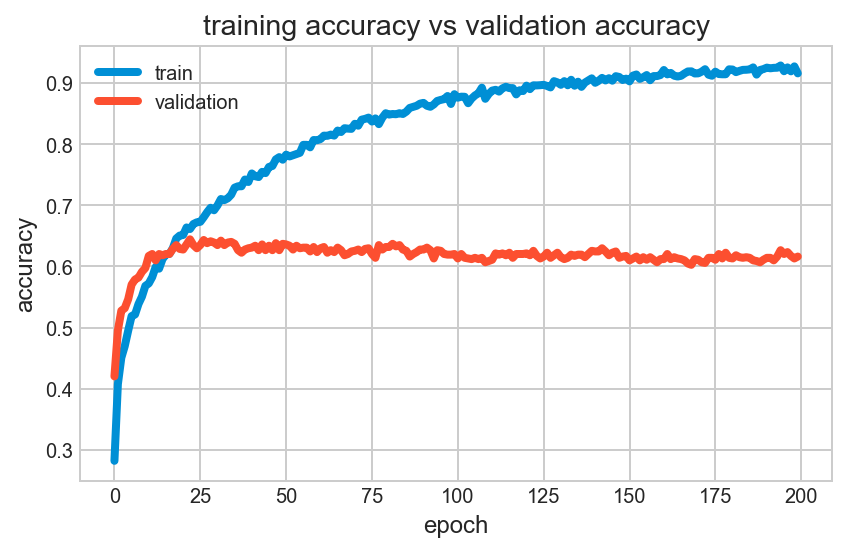

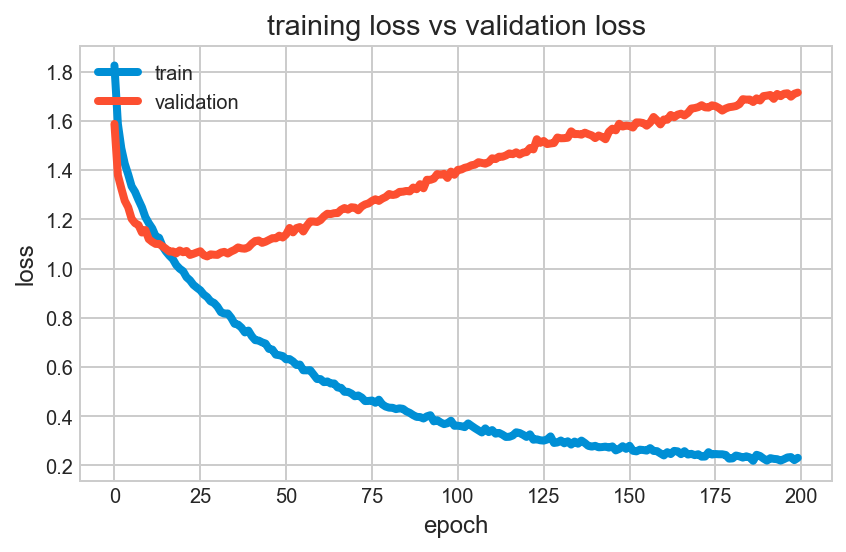

In [19]:
import matplotlib.pyplot as plt

print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('training accuracy vs validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('training loss vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [22]:
from keras.models import load_model
model = load_model('lstm_model.h5') 

MAX_SEQUENCE_LENGTH = 100

model = Sequential()
n, embedding_dims = embedding_mat.shape

model.add(Embedding(n, embedding_dims, weights=[embedding_mat], input_length=MAX_SEQUENCE_LENGTH, trainable=False))
model.add(LSTM(128, dropout=0.6, recurrent_dropout=0.6))
model.add(Dense(7))
model.add(Activation('softmax'))

model.load_weights('weights.best.h5')

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print("Created model and loaded weights from file")

Created model and loaded weights from file


In [25]:
preds = model.predict(X_test,verbose = 2)

preds_mod = []
for i in preds:
    arr = []
    for j,k in enumerate(i):
        if j == np.argmax(i):
            arr.append(1)
        else:
            arr.append(0)
    preds_mod.append(arr)
    
preds_mod = np.asarray(preds_mod)
len(preds_mod)

1128

In [26]:
y_preds = []
for emotions in preds_mod:

    if(np.argmax(emotions) == 0):
        feelings = "shame"
    elif (np.argmax(emotions) == 1):
        feelings = "sadness"
    elif (np.argmax(emotions) == 2):
        feelings = "joy"
    elif (np.argmax(emotions) == 3):
        feelings = "guilt"
    elif (np.argmax(emotions) == 4):
        feelings = "fear"
    elif (np.argmax(emotions) == 5):
        feelings = "disgust"
    elif (np.argmax(emotions) == 6):
        feelings = "anger"
    y_preds.append(feelings)
len(y_preds)

1128

In [27]:
Y_test = []
for emotions in y_test:

    if(np.argmax(emotions) == 0):
        feelings = "shame"
    elif (np.argmax(emotions) == 1):
        feelings = "sadness"
    elif (np.argmax(emotions) == 2):
        feelings = "joy"
    elif (np.argmax(emotions) == 3):
        feelings = "guilt"
    elif (np.argmax(emotions) == 4):
        feelings = "fear"
    elif (np.argmax(emotions) == 5):
        feelings = "disgust"
    elif (np.argmax(emotions) == 6):
        feelings = "anger"
    Y_test.append(feelings)
len(Y_test)

1128

In [28]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(Y_test, y_preds))

             precision    recall  f1-score   support

      anger       0.53      0.54      0.53       174
    disgust       0.59      0.63      0.61       152
       fear       0.68      0.69      0.69       143
      guilt       0.57      0.44      0.50       165
        joy       0.77      0.81      0.79       182
    sadness       0.58      0.66      0.62       146
      shame       0.58      0.54      0.56       166

avg / total       0.62      0.62      0.62      1128



In [29]:
cm = confusion_matrix(Y_test, y_preds)
print(cm)

[[ 94  17  10  19   6  16  12]
 [ 22  96   6   2   5   8  13]
 [ 12   9  99   2   5   9   7]
 [ 23  10  11  73  14  15  19]
 [  5   4   1   5 148  11   8]
 [  8   9   9   9   8  97   6]
 [ 14  18   9  19   6  10  90]]


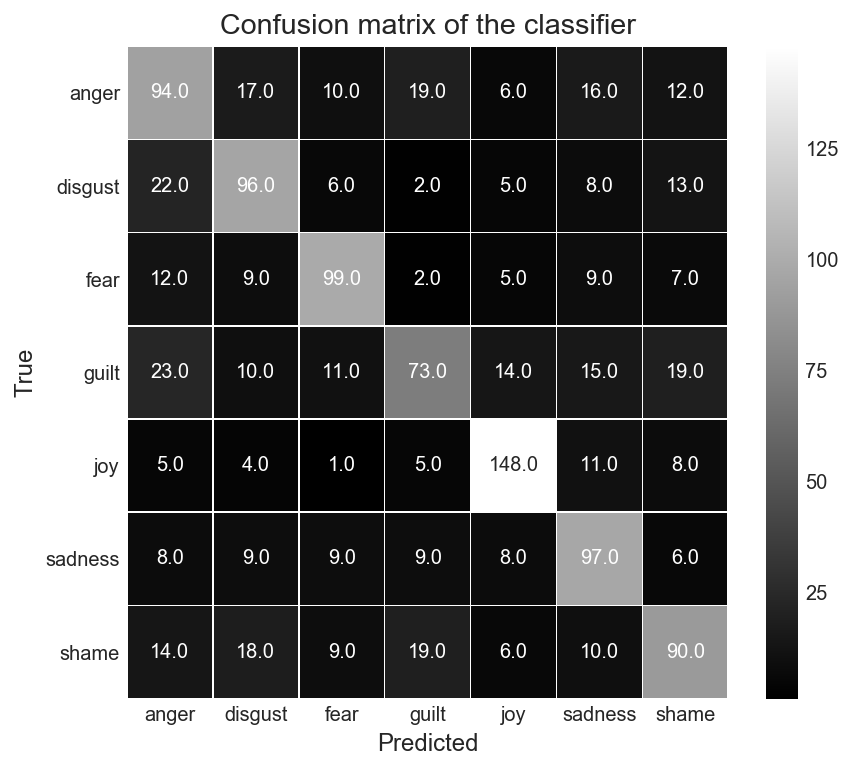

In [31]:
fig = plt.figure(figsize=(6,6))
labels = ['anger','disgust','fear','guilt','joy','sadness','shame']
ax= sns.heatmap(cm, annot=True, fmt=".1f", linewidths=.3, square = False, cmap = plt.cm.gray);
plt.title('Confusion matrix of the classifier')
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
plt.yticks(rotation=0)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [32]:
scores= model.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1] * 100))

acc: 61.79%


In [5]:
#from keras.models import load_model
#model = load_model('lstm_model.h5') 

In [33]:
def predict_emo(msg):
    text = [clean_txt(str(msg[0]))]
    text = tokenizer.texts_to_sequences(text)
    text = pad_sequences(text, maxlen=MAX_SEQUENCE_LENGTH, dtype='int32', value=0)
    emotions = model.predict(text,verbose = 2)[0]
    
    if(np.argmax(emotions) == 0):
        feelings = "shame"
    elif (np.argmax(emotions) == 1):
        feelings = "sadness"
    elif (np.argmax(emotions) == 2):
        feelings = "joy"
    elif (np.argmax(emotions) == 3):
        feelings = "guilt"
    elif (np.argmax(emotions) == 4):
        feelings = "fear"
    elif (np.argmax(emotions) == 5):
        feelings = "disgust"
    elif (np.argmax(emotions) == 6):
        feelings = "anger"

    print('Dorminant Emotion: '+ feelings )
    print("shame: %.2f%%" % (emotions[0]*100 ))
    print("sadness: %.2f%%" % (emotions[1]*100 ))
    print("joy: %.2f%%" % (emotions[2]*100 ))
    print("guilt: %.2f%%" % (emotions[3]*100 ))
    print("fear: %.2f%%" % (emotions[4]*100 ))
    print("disgust: %.2f%%" % (emotions[5]*100 ))
    print("anger: %.2f%%" % (emotions[6]*100 ))

In [37]:
msg = ["Welcome, pleasant to see you today."]
predict_emo(msg)

Dorminant Emotion: joy
shame: 1.26%
sadness: 0.85%
joy: 95.95%
guilt: 0.33%
fear: 0.38%
disgust: 0.72%
anger: 0.52%
